In [1]:
from evophys.models.binding.two_site import TwoSiteNoCoop
from evophys.mcmc.model_inference import ModelInference
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import random as r

/Users/keegan/Desktop/Research/Projects/EvoPhys/env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In this notebook, I demonstrate a very simple usage of our **ModelInference**  class. This class uses MCMC techniques to fit binding data to arbitrary binding models.

To begin, we instantiate a binding model. In order to ensure successful use with **ModelInference**, we will require that our model is any subclass of **evophys.models.binding.binding_model.BindingModel**. This simple class **TwoSiteNoCoop** is one such model, which represents a two-site binding process with no cooperativity. This class was explicitly written for simplicity and testing. 

We instantite the model by specifying the values of the two binding constants.

In [2]:
m = TwoSiteNoCoop({"k1":1e8, "k2":1e5})


To sanity check, let's plot the predicted binding curve and see that it looks about right.

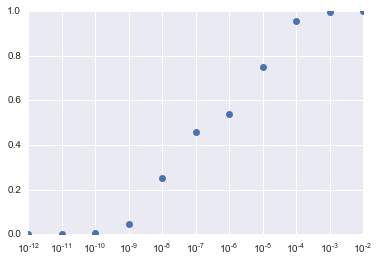

In [3]:
plt.semilogx(m.xvals, m.binding_curve , 'o')


We now create an instantiation of the class **ModelInference**. The constructor requires as input a class which inherits **BindingModel**. This is to ensure that certain methods are available for MCMC, in particular a method called *self.get_binding_curve()*.

In [3]:
inference = ModelInference(m)

We now want to specify what the target data is for parameter inference. This step is actually optional, as the default behavior would use **m.xvals** and **m.binding_curve**. 

Instead, I want to add some experimental noise to the binding curve, so I'll do so and then load that data into the ModelInference.

In [4]:
noisy_data = m.binding_curve + .03*r.randn(len(m.xvals))
inference.load_data(noisy_data)

/Users/keegan/Desktop/Research/Projects/EvoPhys/evophys/mcmc/model_inference.py:28: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if input == None:


With the data loaded and the target model loaded, we can proceed to MCMC. The method *.sample()* does this for us. The parameters should be self explanatory, except for *nwalkers*. This is probably a new concept, and relates to how this particular flavour of MCMC is performed. Instead of simulating one Markov chanin, or several sequentially, we simulate several at the same time.

In [5]:
inference.sample(iterations=1800, nwalkers=20, burnin=500)

After sampling, we now have a DataFrame of our posterior samples.

In [6]:
inference.posterior_samples.head(5)

,k1,k2,sigma
0,6.945892e+06,5.217023e+06,0.152218
1,6.672148e+06,6.082448e+06,0.140960
2,6.672148e+06,6.082448e+06,0.140960
3,6.672148e+06,6.082448e+06,0.140960
4,6.672148e+06,6.082448e+06,0.140960


We may want to look at the trajectories of chains, and verify that the limiting posterior is roughly near the *true* values of the parameters. I've included a (nascent) method for some of this spot-checking.

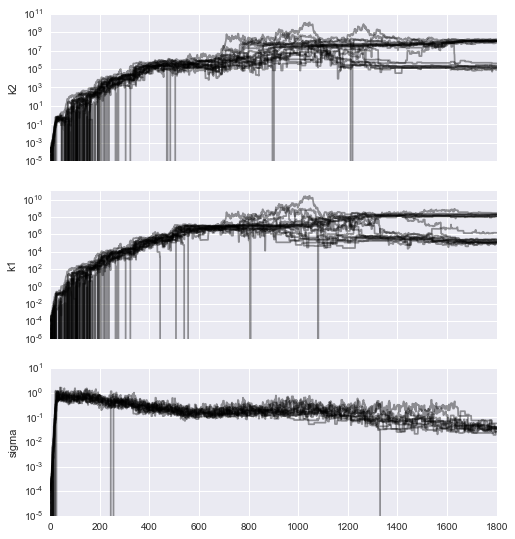

In [7]:
inference.convergence_plot()

We see that the recovered parameters are converged to by nearly all the walkers, with convergence around 10E-8 and 10E-5 as expceted, aside from label-switching non-identifiability between K1 and K2.

So yea, we'll also want to add in some other go-to plotting methods, such as looking at histograms (marginal posteriors) as well as joint posteriors using pandas scatter_matrix or seaborn pairplot. 

/Users/keegan/Desktop/Research/Projects/EvoPhys/env/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


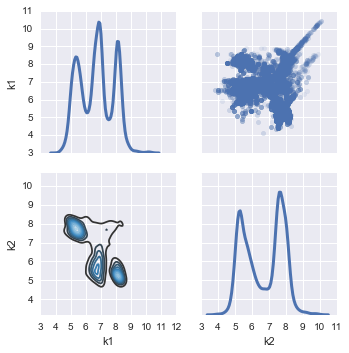

In [8]:
inference.correlation_plot()

Kinda cool here: in the convergence plot and in the correlation plot, you can see the multimodality that arises from the label-switching nonidentifiability. Some runs of the sampler doesn't encounter this mode switches, but sometimes it does. 